# 1. Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import math
import time
import itertools
import datetime
from datetime import datetime
import seaborn as sns

import string
from wordcloud import STOPWORDS

from scipy.stats import skew, boxcox
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

# xgboost
import xgboost as xgb

#Print all rows and columns. Dont hide any
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 2. Configuration

In [2]:
output_featimp = 'feat_xgb_v17_count.csv'
output_sub     = 'sub_xgb_v17_count.csv'
output_oof     = 'oof_xgb_v17_count.csv'

ID = 'tweet_id'
TARGET = 'engagement_count'
NFOLDS = 5
SEED = 2023
NROWS = None
DATA_DIR = "../input"

TRAIN_FILE = "{0}/expert_training.csv".format(DATA_DIR)
TEST_FILE = "{0}/expert_testing.csv".format(DATA_DIR)
SUBMISSION_FILE = "{0}/expert_samplesubmission.csv".format(DATA_DIR)

params = {
    'seed': 0,
    'booster': 'gbtree', # gbtree, gblinear or dart
    'objective': 'count:poisson', # count:poisson, reg:linear, reg:squarederror, reg:squaredlogerror, reg:absoluteerror, reg:gamma, reg:tweedie
    'learning_rate': 0.01, # default=0.3
    'max_depth': 12, # default=6
    'min_child_weight': 10, # default=1
    'subsample': 0.9, # default=1
    'colsample_bytree': 0.8, # default=1
#     'gamma': 0, # default=0
#     'lambda': 1, # default=1
#     'alpha': 0, # default=0
    }

# 3. Functions

In [3]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def xg_eval_rmse(yhat, dtrain):
    y = dtrain.get_label()
    return 'rmse', np.sqrt(((yhat - y) ** 2).mean())

# 4. Data

In [4]:
# read data
train = pd.read_csv(TRAIN_FILE, nrows=NROWS)
test = pd.read_csv(TEST_FILE, nrows=NROWS)

# fill test target
test[TARGET] = 0

# name + text
train['name_time_text'] = train['screen_name'] + " " + train['created_at'] + " "  + train['full_text']
test['name_time_text']  = test['screen_name']  + " " + test['created_at']  + " "  + test['full_text']

# drop duplicates (the first one will be kept)
train_df = train.drop_duplicates(subset=['name_time_text'])
test_df  = test.drop_duplicates(subset=['name_time_text'])

# train test indicator
train_df['train_test'] = 'train'
test_df['train_test']  = 'test'

# concat
train_test_df = pd.concat([train_df, test_df], axis=0)

# flag for duplicated one (last one(test) will have "True")
train_test_df['in_train'] = train_test_df['name_time_text'].duplicated()

# add "in_train" flag to original test data
in_train_df = train_test_df.loc[train_test_df['in_train']]
in_train_df = in_train_df[['name_time_text','in_train']]
test = test.merge(in_train_df, on='name_time_text', how='left')
test['in_train'] = test['in_train'].fillna(False)

# set aside train_test_df after removing duplicates (the first one(train) will be kept). It will be used for feature engineering
train_test_df = train_test_df[~train_test_df['in_train']]

# separate test "in train' and 'not in train'
test_in_train = test[test['in_train']]
test_not_in_train = test[~test['in_train']]

# get target values from train_df
test_in_train = test_in_train.drop([TARGET], axis=1)
test_in_train = test_in_train.merge(train_df[['name_time_text',TARGET]], on='name_time_text', how='left')

# get # of rows
ntrain = train_df.shape[0]
ntest = test_not_in_train.shape[0]

# drop_index
test_not_in_train = test_not_in_train.reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

# get id and target
id_train = train_df[ID]
id_test = test_not_in_train[ID]
y_train = train_df[TARGET]

# make them have the same columns
test_not_in_train = test_not_in_train.drop(['in_train'], axis=1)
test_not_in_train['train_test'] = 'test'

# concatenate train and test
train_test = pd.concat([train_df, test_not_in_train]).reset_index(drop=True)

C:\Users\kkudo\AppData\Local\Temp\ipykernel_12036\2301700253.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['train_test'] = 'train'
C:\Users\kkudo\AppData\Local\Temp\ipykernel_12036\2301700253.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['train_test']  = 'test'


# 5. Preprocessing

##### train_test:   train does not have duplicates, but test has duplicates
##### train_test_df:it does not have duplicates. It will be used for feature engineering

In [5]:
names = ['songmyeongho1',
 'web3_inu',
 'ethereum',
 'NFTcollector00',
 'web3',
 'PulsechainCom',
 'Bitcoin',
 'magicianpromos',
 'cryptoBILLnfts',
 'cryptopunksnfts',
 'cryptoworld_gg',
 'russnft',
 'Crypto_Inside_',
 'DeGodsNFT',
 'BabyDogeNFTs',
 'CryptoCapo_',
 'MrsunNFT',
 'kris',
 'AnuelNFT',
 'cryptocom',
 'NftCryptosArt']

# train_test.query(f'screen_name in {names}')
train_test.loc[train_test['screen_name'].isin(names),'highprofile'] = 1
train_test['highprofile'] = train_test['highprofile'].fillna(0)
train_test['highprofile'] = train_test['highprofile'].astype(int)

train_test_df.loc[train_test_df['screen_name'].isin(names),'highprofile'] = 1
train_test_df['highprofile'] = train_test_df['highprofile'].fillna(0)
train_test_df['highprofile'] = train_test_df['highprofile'].astype(int)

In [6]:
X = pd.DataFrame()

# screen_name
X['highprofile'] = train_test['highprofile']
# X['highprofile'] = X['highprofile'].astype(int)

## created at
# convert 'created_at' from object to datetime
train_test['created_at'] = pd.to_datetime(train_test['created_at'])
train_test['dayname'] = train_test['created_at'].dt.strftime('%A')
train_test['date'] = pd.to_datetime(train_test['created_at']).dt.date
train_test['yrmonth'] = (pd.to_datetime(train_test['created_at']).dt.year-2013)*12+pd.to_datetime(train_test['created_at']).dt.month
train_test['year'] = pd.to_datetime(train_test['created_at']).dt.year

train_test_df['created_at'] = pd.to_datetime(train_test_df['created_at'])
train_test_df['dayname'] = train_test_df['created_at'].dt.strftime('%A')
train_test_df['date'] = pd.to_datetime(train_test_df['created_at']).dt.date
train_test_df['yrmonth'] = (pd.to_datetime(train_test_df['created_at']).dt.year-2013)*12+pd.to_datetime(train_test_df['created_at']).dt.month
train_test_df['year'] = pd.to_datetime(train_test_df['created_at']).dt.year


# ymd
X['created_at_year'] = pd.to_datetime(train_test['created_at']).dt.year
X['created_at_month'] = pd.to_datetime(train_test['created_at']).dt.month
X['created_at_yrmonth'] = (pd.to_datetime(train_test['created_at']).dt.year-2013)*12+pd.to_datetime(train_test['created_at']).dt.month

# day name
tmp = pd.get_dummies(train_test['dayname'], prefix='dayname', prefix_sep='_')
X = pd.concat([X, tmp], axis=1)

# le = LabelEncoder()
# X['dayname']= le.fit_transform(train_test['dayname'])


## full text
# count of words
X['count_words'] = train_test['full_text'].str.split().map(lambda x: len(x))

# count of characters
X['count_chars'] = train_test['full_text'].str.len()

# count of unique workds
X['unique_word_count'] = train_test['full_text'].apply(lambda x: len(set(str(x).split())))

# count of stop word
X['stop_word_count'] = train_test['full_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
X['url_count'] = train_test['full_text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
X['mean_word_length'] = train_test['full_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# punctuation_count
X['punctuation_count'] = train_test['full_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
X['hashtag_count'] = train_test['full_text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
X['mention_count'] = train_test['full_text'].apply(lambda x: len([c for c in str(x) if c == '@']))


## tweet frequency - for aggregation, make sure to use "train_test_df" (not "train_test")
# same day
tmp = train_test_df.groupby(['screen_name','date'])['full_text'].count().reset_index()
tmp = tmp.rename(columns={"full_text": "tweet_count_same_day"})
tmp.head()

train_test = train_test.merge(tmp, how='left', on=['screen_name','date'])
train_test['tweet_count_same_day'] = train_test['tweet_count_same_day'].fillna(0)
X['tweet_count_same_day'] = train_test['tweet_count_same_day']

# same month
tmp = train_test_df.groupby(['screen_name','yrmonth'])['full_text'].count().reset_index()
tmp = tmp.rename(columns={'full_text': 'tweet_count_same_month'})
tmp.head()

train_test = train_test.merge(tmp, how='left', on=['screen_name','yrmonth'])
train_test['tweet_count_same_month'] = train_test['tweet_count_same_month'].fillna(0)
X['tweet_count_same_month'] = train_test['tweet_count_same_month']

# same year
tmp = train_test_df.groupby(['screen_name','year'])['full_text'].count().reset_index()
tmp = tmp.rename(columns={'full_text': 'tweet_count_same_year'})
tmp.head()

train_test = train_test.merge(tmp, how='left', on=['screen_name','year'])
train_test['tweet_count_same_yearonth'] = train_test['tweet_count_same_year'].fillna(0)
X['tweet_count_same_year'] = train_test['tweet_count_same_year']


## display_text_range
X['display_text_range'] = train_test['display_text_range']
# X['display_text_range_bin'] = pd.cut(train_test['display_text_range'], bins=10, labels=False)

## in_reply_to_screen_name
X['in_reply_to_screen_name_flg'] = train_test['in_reply_to_screen_name'].apply(lambda x : 0 if x is np.nan else 1)


## is_quote_status
X['is_quote_status'] = train_test['is_quote_status'].apply(lambda x : 1 if x else 0)


## includes_media
X['includes_media'] = train_test['includes_media'].apply(lambda x : 1 if x else 0)


## hashtags
#X['hashtag_count'] = len(train_test['hashtags'].split(', '))
X['hashtag_Bitcoin'] = train_test['hashtags'].str.contains('Bitcoin')
X['hashtag_Bitcoin'] = X['hashtag_Bitcoin'].apply(lambda x : 1 if x else 0)

X['hashtag_Crypto'] = train_test['hashtags'].str.contains('Crypto')
X['hashtag_Crypto'] = X['hashtag_Crypto'].apply(lambda x : 1 if x else 0)


## user_mentions
X['user_mentions_flg'] = train_test['user_mentions'].apply(lambda x : 0 if x is np.nan else 1)

In [7]:
# sentimental analysis scores
sent = pd.read_csv('../00_SentimentAnalysis/sentiment_analysis_scores3.csv', nrows=NROWS)

train_test = train_test.merge(sent, on='tweet_id', how='left')
X['sent_score'] = train_test['sent_score']
X['sent_label_NEG'] = train_test['sent_label_NEG']
X['sent_label_NEU'] = train_test['sent_label_NEU']
X['sent_label_POS'] = train_test['sent_label_POS']

In [8]:
# followers
fol = pd.read_csv('../00_EDA/screen_names_followers.csv', nrows=NROWS)

train_test = train_test.merge(fol, on='screen_name', how='left')
X['followers'] = train_test['followers']

In [9]:
# separate train and test
x_train = X.iloc[:ntrain,:]
x_test = X.iloc[ntrain:,:]

In [10]:
## OOF target
oof_nfolds = 10

kfold = KFold(n_splits=oof_nfolds, random_state=SEED, shuffle=True)

oof_train = np.zeros((ntrain,))
oof_test = np.zeros((ntest,))
oof_test_skf = np.empty((oof_nfolds, ntest))


for fold_id, (train_idx, valid_idx) in enumerate(kfold.split(train_df)):
    tr_df = train_df.iloc[train_idx]
    vl_df = train_df.iloc[valid_idx]
    
    # screen_name
    tmp = tr_df.groupby(['screen_name'])[TARGET].mean()
    tmp = pd.DataFrame(tmp).reset_index().rename(columns={TARGET: 'oof_screen_name'})
    tmp_mean = tr_df[TARGET].mean()
    
    a = vl_df[[ID,'screen_name']].merge(tmp, on='screen_name', how='left')
    a['oof_screen_name'] = a['oof_screen_name'].fillna(tmp_mean)
    oof_train[valid_idx] = a['oof_screen_name']
    
    a = test_not_in_train[[ID,'screen_name']].merge(tmp, on='screen_name', how='left')
    a['oof_screen_name'] = a['oof_screen_name'].fillna(tmp_mean)
    oof_test_skf[fold_id, :] = a['oof_screen_name']
    
oof_test[:] = oof_test_skf.mean(axis=0)


x_train['oof_screen_name'] = oof_train
x_test['oof_screen_name'] = oof_test

C:\Users\kkudo\AppData\Local\Temp\ipykernel_12036\1776465337.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['oof_screen_name'] = oof_train
C:\Users\kkudo\AppData\Local\Temp\ipykernel_12036\1776465337.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['oof_screen_name'] = oof_test


# 5. Cross Validation

In [11]:
# modeling with cross validation
kfold = StratifiedKFold(n_splits=NFOLDS, random_state=SEED, shuffle=True)

oof_train = np.zeros((ntrain,))
oof_test = np.zeros((ntest,))
oof_test_skf = np.empty((NFOLDS, ntest))

feat_imp = np.zeros((NFOLDS,x_train.shape[1]))

d_test = xgb.DMatrix(x_test)

for fold_id, (train_idx, valid_idx) in enumerate(kfold.split(x_train, y_train)):
    
    print("\nFold %d / %d" % (fold_id + 1, NFOLDS))

    d_train = xgb.DMatrix(x_train.iloc[train_idx], label=y_train[train_idx])
    d_valid = xgb.DMatrix(x_train.iloc[valid_idx], label=y_train[valid_idx])
    watchlist = [(d_train, 'train'), (d_valid, 'eval')]

    model = xgb.train(params,
                      d_train,
                      100000,
                      evals=watchlist,
                      verbose_eval = 100,
                      early_stopping_rounds=50,
#                       obj=fair_obj,
                      custom_metric=xg_eval_rmse)
    
    oof_train[valid_idx] = model.predict(d_valid, ntree_limit=model.best_ntree_limit)
    oof_test_skf[fold_id, :] = model.predict(d_test, ntree_limit=model.best_ntree_limit)

    feat_imp_out = model.get_score(importance_type='gain')
    for i,x in enumerate(model.get_score(importance_type='gain')):
        feat_imp[fold_id,i] = feat_imp_out[x]
    
oof_test[:] = oof_test_skf.mean(axis=0)

# fill negative with 0
oof_train[oof_train<0] = 0
oof_test[oof_test<0] = 0

feat_imp = feat_imp.mean(axis=0)
feat_imp = pd.DataFrame(sorted(zip(feat_imp, x_train.columns),reverse = True), columns=['Gain','Feature'])
feat_imp.to_csv(output_featimp, index=False)

# OOF RMSE
print('\nOOF RMSE: {:.4f}'.format(rmse(oof_train, y_train)))

print('OOF RMSE in 0:24069:   {:.4f}'.format(rmse(oof_train[0:24069], y_train[0:24069])))
print('OOF RMSE in 24069:END: {:.4f}'.format(rmse(oof_train[24069:], y_train[24069:])))


Fold 1 / 5
[0]	train-poisson-nloglik:946.01400	train-rmse:1042.55688	eval-poisson-nloglik:929.87290	eval-rmse:823.11078


D:\Programs\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[100]	train-poisson-nloglik:855.24648	train-rmse:1042.49341	eval-poisson-nloglik:840.16378	eval-rmse:823.03131
[200]	train-poisson-nloglik:764.97765	train-rmse:1042.36633	eval-poisson-nloglik:750.96304	eval-rmse:822.87231
[300]	train-poisson-nloglik:675.48979	train-rmse:1042.11279	eval-poisson-nloglik:662.65871	eval-rmse:822.55518
[400]	train-poisson-nloglik:587.43756	train-rmse:1041.61047	eval-poisson-nloglik:575.89230	eval-rmse:821.92804
[500]	train-poisson-nloglik:501.42448	train-rmse:1040.62292	eval-poisson-nloglik:491.67570	eval-rmse:820.70367
[600]	train-poisson-nloglik:418.43643	train-rmse:1038.70727	eval-poisson-nloglik:411.02405	eval-rmse:818.34729
[700]	train-poisson-nloglik:339.75517	train-rmse:1035.05066	eval-poisson-nloglik:335.65342	eval-rmse:813.92297
[800]	train-poisson-nloglik:266.84319	train-rmse:1028.25195	eval-poisson-nloglik:267.07693	eval-rmse:805.83167
[900]	train-poisson-nloglik:201.44587	train-rmse:1015.96143	eval-poisson-nloglik:207.50116	eval-rmse:791.64825
[

D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



Fold 2 / 5
[0]	train-poisson-nloglik:954.24744	train-rmse:1059.15625	eval-poisson-nloglik:896.94325	eval-rmse:733.46027
[100]	train-poisson-nloglik:863.04136	train-rmse:1059.09338	eval-poisson-nloglik:809.39119	eval-rmse:733.37335
[200]	train-poisson-nloglik:772.31364	train-rmse:1058.96765	eval-poisson-nloglik:722.27470	eval-rmse:733.19910
[300]	train-poisson-nloglik:682.39126	train-rmse:1058.71667	eval-poisson-nloglik:636.20350	eval-rmse:732.85266
[400]	train-poisson-nloglik:593.88487	train-rmse:1058.21973	eval-poisson-nloglik:551.67556	eval-rmse:732.16864
[500]	train-poisson-nloglik:507.44971	train-rmse:1057.24231	eval-poisson-nloglik:469.74923	eval-rmse:730.83496
[600]	train-poisson-nloglik:423.99492	train-rmse:1055.34509	eval-poisson-nloglik:392.09795	eval-rmse:728.29706
[700]	train-poisson-nloglik:344.83165	train-rmse:1051.71997	eval-poisson-nloglik:319.41653	eval-rmse:723.53143
[800]	train-poisson-nloglik:271.46684	train-rmse:1044.97656	eval-poisson-nloglik:254.37763	eval-rmse:7

D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



Fold 3 / 5
[0]	train-poisson-nloglik:973.95698	train-rmse:1075.60498	eval-poisson-nloglik:818.10100	eval-rmse:630.48169
[100]	train-poisson-nloglik:881.34727	train-rmse:1075.54224	eval-poisson-nloglik:735.80276	eval-rmse:630.38654
[200]	train-poisson-nloglik:789.22612	train-rmse:1075.41638	eval-poisson-nloglik:654.01012	eval-rmse:630.19611
[300]	train-poisson-nloglik:697.88364	train-rmse:1075.16553	eval-poisson-nloglik:573.12446	eval-rmse:629.81683
[400]	train-poisson-nloglik:607.97758	train-rmse:1074.66846	eval-poisson-nloglik:493.76804	eval-rmse:629.06769
[500]	train-poisson-nloglik:520.11780	train-rmse:1073.69092	eval-poisson-nloglik:416.90905	eval-rmse:627.60779
[600]	train-poisson-nloglik:435.28203	train-rmse:1071.79285	eval-poisson-nloglik:344.08342	eval-rmse:624.83008
[700]	train-poisson-nloglik:354.79125	train-rmse:1068.16650	eval-poisson-nloglik:276.73214	eval-rmse:619.66486
[800]	train-poisson-nloglik:279.88085	train-rmse:1061.39087	eval-poisson-nloglik:217.26362	eval-rmse:6

D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



Fold 4 / 5
[0]	train-poisson-nloglik:893.19680	train-rmse:769.07056	eval-poisson-nloglik:1141.14166	eval-rmse:1630.74622
[100]	train-poisson-nloglik:805.78690	train-rmse:768.98767	eval-poisson-nloglik:1038.01607	eval-rmse:1630.70007
[200]	train-poisson-nloglik:718.87270	train-rmse:768.82178	eval-poisson-nloglik:935.39691	eval-rmse:1630.60767
[300]	train-poisson-nloglik:632.75108	train-rmse:768.49078	eval-poisson-nloglik:833.64910	eval-rmse:1630.42334
[400]	train-poisson-nloglik:548.03019	train-rmse:767.83545	eval-poisson-nloglik:733.45069	eval-rmse:1630.05786
[500]	train-poisson-nloglik:465.37907	train-rmse:766.54761	eval-poisson-nloglik:635.50716	eval-rmse:1629.33936
[600]	train-poisson-nloglik:385.73339	train-rmse:764.05054	eval-poisson-nloglik:541.37618	eval-rmse:1627.95361
[700]	train-poisson-nloglik:310.49764	train-rmse:759.29175	eval-poisson-nloglik:452.64811	eval-rmse:1625.33386
[800]	train-poisson-nloglik:240.97446	train-rmse:750.44568	eval-poisson-nloglik:370.64283	eval-rmse:

D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



Fold 5 / 5
[0]	train-poisson-nloglik:946.51358	train-rmse:1033.47913	eval-poisson-nloglik:927.87467	eval-rmse:867.69550
[100]	train-poisson-nloglik:855.72600	train-rmse:1033.41504	eval-poisson-nloglik:838.23395	eval-rmse:867.62012
[200]	train-poisson-nloglik:765.41985	train-rmse:1033.28674	eval-poisson-nloglik:749.20121	eval-rmse:867.46954
[300]	train-poisson-nloglik:675.89992	train-rmse:1033.03076	eval-poisson-nloglik:661.27293	eval-rmse:867.17017
[400]	train-poisson-nloglik:587.72980	train-rmse:1032.52319	eval-poisson-nloglik:575.35325	eval-rmse:866.58227
[500]	train-poisson-nloglik:501.72065	train-rmse:1031.52661	eval-poisson-nloglik:492.02520	eval-rmse:865.43793
[600]	train-poisson-nloglik:418.72843	train-rmse:1029.59228	eval-poisson-nloglik:412.71628	eval-rmse:863.25153
[700]	train-poisson-nloglik:340.00980	train-rmse:1025.89697	eval-poisson-nloglik:338.68263	eval-rmse:859.16077
[800]	train-poisson-nloglik:266.93072	train-rmse:1019.00433	eval-poisson-nloglik:274.76505	eval-rmse:8

D:\Programs\anaconda3\lib\site-packages\xgboost\core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



OOF RMSE: 874.8134
OOF RMSE in 0:24069:   199.1369
OOF RMSE in 24069:END: 2816.9212


Text(0, 0.5, 'actual')

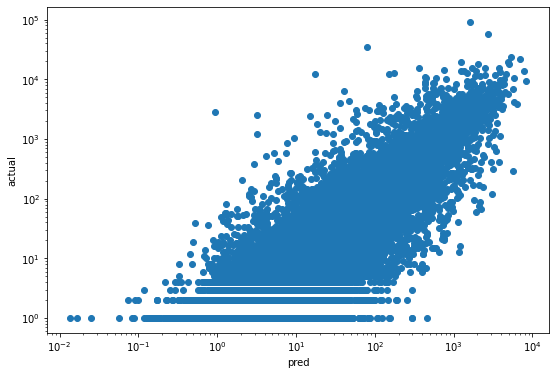

In [12]:
# checking actual vs. expected
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 6))
ax.set_xscale("log")
ax.set_yscale("log")

plt.scatter(oof_train, y_train)
plt.xlabel('pred')
plt.ylabel('actual')

Text(0, 0.5, 'actual')

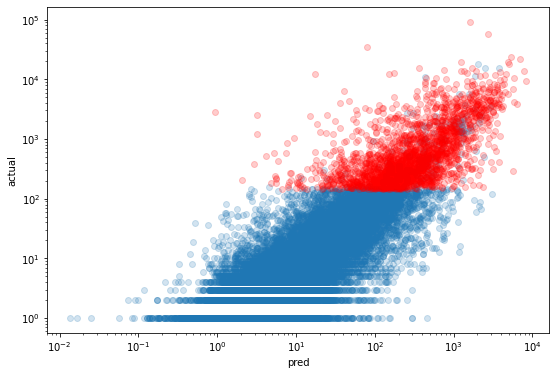

In [13]:
# checking actual vs. expected
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9, 6))
ax.set_xscale("log")
ax.set_yscale("log")

plt.scatter(oof_train[0:24069], y_train[0:24069], alpha=0.2)
plt.scatter(oof_train[24069:], y_train[24069:], alpha=0.2, color='red')
plt.xlabel('pred')
plt.ylabel('actual')

# 6. Submission

In [14]:
# oof
oof = pd.DataFrame()
oof[ID] = id_train
oof[TARGET] = oof_train
oof.loc[oof[TARGET]<0, TARGET] = 0
oof.to_csv(output_oof, index=False)

In [15]:
### submission
# not_in_train
sub = pd.DataFrame()
sub[ID] = id_test
sub[TARGET] = oof_test

# in_train
sub = pd.concat([sub, test_in_train[[ID, TARGET]]], axis=0)
sub = sub.sort_values(by=[ID])
sub.loc[sub[TARGET]<0, TARGET] = 0

# save
sub.to_csv(output_sub, index=False)

# ...END